### Some terms you need to understand for understanding Large Language Models
  - logits
  - softmax
  - cross entropy
  - one hot encoding
  - encoding/embedding
  - tokens, tokenizer
  - attention
    - multi-head attention
  - positional encoding
    - rotary positional encoding (Used in LLama)
  - transformer
    - encoder
    - decoder
    - Residual Connection
    - Feed Forward Layer
    - Layer Normalization
      - LLama suggests RMSNorm instead <https://arxiv.org/abs/1910.07467>
  - **optimizer**
    - Stochastic Gradient Descent (SGD)
    - Weight Regularization (L1/L2)
  - Important players in the AI Ecosystem
    - [huggingface (datasets, transformers)](https://huggingface.co/docs/transformers/training)
    - [unsloth (fast fine tune)](https://github.com/unslothai/unsloth)
  - How to train/fine tune!

In [ ]:
import torch
from torch.nn import functional as F
from torch import nn
from tinytorch.MyStuff import *
from tinytorch.tensorhelpers import *
import math
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Ellipse
from matplotlib.text import OffsetFrom

import random

### The [AdamW optimizer](https://pytorch.org/docs/2.2/generated/torch.optim.AdamW.html) is based on [DECOUPLED WEIGHT DECAY REGULARIZATION](https://arxiv.org/abs/1711.05101)
  - Original "Adam" optimizer [Kingma & Ba](https://arxiv.org/abs/1412.6980)
  - Name comes from "Adaptive Moment Estimation"
#### Stochastic Gradient Descent (SGD) 
  - Used when training data is so large that we are forced to used subsets of them while training!
  - optimizers (such as`Adam` and `AdamW`) are plugins that is used to manage the `loss`, `gradients`, `learning rate`, and the `weights` during training.
  - `Adam` and `AdamW` are actually known as **Adaptive SGD** algorithms.

In [ ]:
## What happens when "xs" below is very very large??? (i.e. on the order of billions or more!)
def doPass(nn, xs, ys, npass=20, ValType=torch.tensor, Zeros=torch.zeros, dtype=float, LR=0.05):
  assert len(xs) == len(ys), f'{len(xs)=} elements but {len(ys)=}'
  assert isinstance(nn, MLP), f'{type(MLP)} is not a {MLP}'
  YS = [ ValType(k,dtype=dtype) for k in ys ]
  #ebugPush(Tensor, Tensor.backward, Tensor.binaryOpHelper, Tensor.unaryOpHelper)
  losses = []
  for k in range(npass):
    # forward pass
    # produce len(xs) number of tensors
    ypred = [ nn(ValType(x,dtype=dtype)) for x in xs ]  ## <<- NOT SGD!
    loss = sum((yout-ygt)**2 for ygt, yout in zip(YS, ypred))
    print(f'pass {k} {loss.item()}')
    # backward pass
    for p in nn.parameters():
      p.grad = Zeros(*p.shape, dtype=float)
    loss.backward()
    
    # update
    # note that in a real NN, the following manual adjustment would be handled automatically by the gradient descent function
    # i.e. OPTIMIZER DOES SOMETHING WITH THE .grad fields and the Learning Rate!, and replaces this entire loop
    for p in nn.parameters():
      pD = -LR * p.grad  
      # print(Shapes(p=p, MINUS_EQUAS='', pD=pD, LR=LR, pG=p.grad))
      p.requires_grad = False
      p += pD
      p.requires_grad = True
    losses.append(loss)
  return losses

#### torch.utils.data.Dataset
  - (https://pytorch.org/docs/2.3/data.html)
  - Thousands of different datasets are already available online

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], eps=1e-9))
## sometimes, we may want to restrict the gradient update to specific parameters of the model

def trainLoop(nn, data, optimizer, lossFN, npass=20):
  losses = []
  for k in range(npass):
    # forward pass
    x, y = data.get_batch() # get a random sample x and the expected output y
    ypred = nn(x) # evaluate the nn
    loss = lossFN(ypred, y) # calculate the loss against the expected value
    losses.append(loss.item())
    # backward pass
    loss.backward()
    optimizer.step() ## <-- this takes care of modifying the parameters and the .grad values!
    # flush the gradients as soon as we can, no need for this memory anymore
    optimizer.zero_grad(set_to_none=True)
  return losses

### Adam Pseudocode
  - *Algorithm 1*: `Adam`, our proposed algorithm for stochastic optimization. See section 2 for details,
and for a slightly more efficient (but less clear) order of computation.
     $g_t^2$ indicates the elementwise square $g_t \odot g_t$.

     Good default settings for the tested machine learning problems are $α = 0.001$, $β_1 = 0.9$, $β_2 = 0.999$ and $\epsilon = 10^{−8}$.
     All operations on vectors are element-wise. With $β_1^t$ and $β_2^t$ we denote $β_1$ and $β_2$ to the power $t$.

    - Require: $α$: Stepsize
    - Require: $β_1$ , $β_2 ∈ [0, 1)$: Exponential decay rates for the moment estimates
    - Require: $f (θ)$: Stochastic objective function with parameters θ
    - Require: $θ_0$ : Initial parameter vector
      - $m_0  ← 0$  (Initialize 1st moment vector)
      - $v_0 ← 0$ (Initialize 2nd moment vector)
      - $t ← 0$ (Initialize timestep)
    - while $θ_t$ not converged do
      - $t ← t + 1$
      - $g_t ← ∇_θ f_t (θ_{t−1} )$ (Get gradients w.r.t. stochastic objective at timestep t)
      - $m_t ← β_1 · m_{t−1} + (1 − β_1 ) · g_t$ (Update biased first moment estimate)
      - $v_t ← β_2 · v_{t−1} + (1 − β_2) · g_t^2$ (Update biased second raw moment estimate)
      - $\displaystyle \hat{m_t} \gets \frac{m_t}{1 - \beta^t_1}$  (Compute bias-corrected first moment estimate)
      - $\displaystyle \hat{v_t} \gets \frac{v_t}{1 - \beta^t_2}$  (Compute bias-corrected second moment estimate)
      - $\theta_t \gets \theta_{t-1} - \alpha \cdot \frac{\hat{m_t}}{\sqrt{\hat{v_t}} + \epsilon}$ (update parameters!)
      - end while
    - return $θ_t$ (Resultingparameters)

### What is [Regularization?](https://medium.com/analytics-vidhya/regularization-understanding-l1-and-l2-regularization-for-deep-learning-a7b9e4a409bf)
  - It is a class of numerical techniques to reduce "overfitting"
  - L1 stands for first degree (Least Absolute Deviation), i.e. $loss = \sum | y_i - f(x_i) |$
  - L2 stands for second degree, i.e. $loss = \sum  (y_i - f(x_i))^2 $
    - Least Squares Error
  - See this <http://www.chioka.in/differences-between-l1-and-l2-as-loss-function-and-regularization/>
  - L1 Regularization adds a scaled sum of weights to the loss
  - L2 Regularization adds a scaled sum of squares of weights value to the loss
  - L1 is most useful if your weights are **sparse** (i.e. much of your matrix is zero!)
  - L2 is most useful if your weights are **not sparse**

##### AdamW algorighm
  - 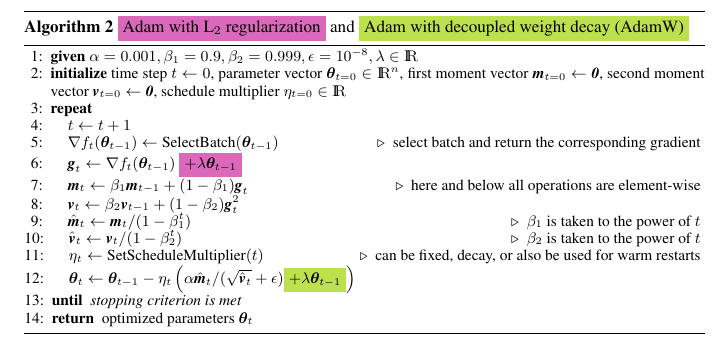